In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support

### Prime Number Functions

**`is_prime(n)`**  
- Checks if a number `n` is prime.
- Returns `True` if `n > 1` and divisible only by 1 and itself, else `False`.

**`next_prime(n)`**  
- Finds the next prime number ≥ `n`.
- Uses `is_prime` to incrementally check numbers until a prime is found.


In [3]:
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

def next_prime(n):
    while not is_prime(n):
        n += 1
    return n


### Loading and Merging Datasets

1. **Load Datasets**  
   - `ratings`: Contains user ratings for movies (`rating.csv`).  
   - `movies`: Contains movie information (`movie.csv`).

2. **Merge Datasets**  
   - Combine `ratings` and `movies` on the `movieId` column using an inner join.  
   - Result: A unified DataFrame `df` with movie ratings and details.

3. **Preview the Data**  
   - Display the first few rows of the merged DataFrame using `df.head()`.


In [4]:
ratings = pd.read_csv('rating.csv')  
movies = pd.read_csv('movie.csv')    

df = pd.merge(ratings, movies, on='movieId', how='inner')


In [83]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [4]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


In [6]:
df.nunique()

userId         138493
movieId         26744
rating             10
timestamp    15351121
title           26729
genres           1329
dtype: int64

### MinHash Implementation from Scratch

**`minhash_scratch(user_movie_dict, perm)`**

1. **Purpose**  
   - Generate MinHash signatures for each user based on the movies they have rated.  

2. **Parameters**  
   - `user_movie_dict`: Dictionary where keys are users and values are lists of movie IDs.  
   - `perm`: Number of hash functions (permutations) to use for the MinHash computation.

3. **Logic**  
   - **Generate Unique Movie Set:** Extract all unique movie IDs across all users.  
   - **Hash Functions:**  
     - Generate `perm` random coefficients `a` and `b` for hash functions.  
     - Use a prime number `p` greater than the total number of movies to ensure good hashing.  
   - **Initialization:** Create a dictionary to store MinHash signatures (`user_sign`), initialized with infinity (`float('inf')`) for each permutation.  
   - **Hash Computation:**  
     - For each user and their rated movies:  
       - Compute the hash value for each movie using \( \text{hash} = (a \cdot \text{movieId} + b) \% p \).  
       - Update the user's MinHash signature with the smallest hash value for each permutation.

4. **Return**  
   - `user_sign`: Dictionary containing MinHash signatures for each user.



In [12]:
def compute_primehash(user_movie_dict, perm, counter=0):
    """Compute the Prime MinHash signatures."""
    all_movies = set(movie for movies in user_movie_dict.values() for movie in movies)
    a_vals = [random.randint(1, len(all_movies)) for _ in range(perm)]
    b_vals = [random.randint(0, len(all_movies)) for _ in range(perm)]
    p = next_prime(len(all_movies) + 1)

    user_sign = {user: [float('inf')] * perm for user in user_movie_dict}

    for user, movies in user_movie_dict.items():
        for movie in movies:
            for i in range(perm):
                hash_value = (a_vals[i] * movie + b_vals[i]) % p
                if hash_value < user_sign[user][i]:
                    user_sign[user][i] = hash_value
        counter += 1
        if counter % 15000 == 0:
            print(f"Computing hash values for user {user}")
    return user_sign

def compute_xorhash(user_movie_dict, perm, counter=0):
    """Compute the XOR Hash signatures."""
    all_movies = set(movie for movies in user_movie_dict.values() for movie in movies)
    a_vals = [random.randint(1, len(all_movies)) for _ in range(perm)]
    b_vals = [random.randint(0, len(all_movies)) for _ in range(perm)]
    user_sign = {user: [float('inf')] * perm for user in user_movie_dict}

    for user, movies in user_movie_dict.items():
        for movie in movies:
            for i in range(perm):
                xor_value = movie ^ (a_vals[i] + b_vals[i])
                if xor_value < user_sign[user][i]:
                    user_sign[user][i] = xor_value
        counter += 1
        if counter % 15000 == 0:
            print(f"Computing hash values for user {user}")
    return user_sign

def compute_polyhash(user_movie_dict, perm, counter=0):
    """Compute the Polynomial Hash signatures."""
    all_movies = set(movie for movies in user_movie_dict.values() for movie in movies)
    a_vals = [random.randint(1, len(all_movies)) for _ in range(perm)]
    b_vals = [random.randint(0, len(all_movies)) for _ in range(perm)]
    p = next_prime(len(all_movies) + 1)
    user_sign = {user: [float('inf')] * perm for user in user_movie_dict}

    for user, movies in user_movie_dict.items():
        for movie in movies:
            for i in range(perm):
                poly_value = (a_vals[i] * (movie ** 2) + b_vals[i] * movie + 1) % p
                if poly_value < user_sign[user][i]:
                    user_sign[user][i] = poly_value
        counter += 1
        if counter % 15000 == 0:
            print(f"Computing hash values for user {user}")
    return user_sign


### Creating `user_movie_dict`

- **Group by `userId`:** Groups the DataFrame by users.
- **Extract `movieId`:** Collects all movie IDs each user has rated.
- **Convert to List:** Combines the movie IDs into lists for each user.
- **Convert to Dictionary:** Creates a dictionary where:
  - Keys: `userId` (user identifiers).
  - Values: Lists of `movieId` (movies rated by the user).

**Result:**  
A dictionary `user_movie_dict` where each user is associated with the list of movies they have rated.


In [5]:
user_movie_dict = df.groupby('userId')['movieId'].apply(list).to_dict()

In [13]:
sign_prime = compute_primehash(user_movie_dict, 100)

Computing hash values for user 15000
Computing hash values for user 30000
Computing hash values for user 45000
Computing hash values for user 60000
Computing hash values for user 75000
Computing hash values for user 90000
Computing hash values for user 105000
Computing hash values for user 120000
Computing hash values for user 135000


In [10]:
sign_xor = compute_xorhash(user_movie_dict, 100)

Computing hash values for user 15000
Computing hash values for user 30000
Computing hash values for user 45000
Computing hash values for user 60000
Computing hash values for user 75000
Computing hash values for user 90000
Computing hash values for user 105000
Computing hash values for user 120000
Computing hash values for user 135000


In [11]:
sign_poly = compute_polyhash(user_movie_dict, 100)

Computing hash values for user 15000
Computing hash values for user 30000
Computing hash values for user 45000
Computing hash values for user 60000
Computing hash values for user 75000
Computing hash values for user 90000
Computing hash values for user 105000
Computing hash values for user 120000
Computing hash values for user 135000


### Check which MinHash algorithm has the best accuracy

#### Why Do We Use a Sample of 2000 Users to Compare Hash Functions in a Dataset with ~135,000 Users?

When working with large datasets, such as a user-movie dataset with approximately 135,000 users, it is often computationally expensive and time-consuming to calculate metrics across all possible user pairs. For example, comparing all pairs of users would involve analyzing over 9 billion pairs \((\binom{135,000}{2})\), which is infeasible for many tasks. Instead, we use a representative **sample** of the dataset to make accurate and efficient comparisons.


##### **Key Idea: Representativeness of the Sample**
Using a random sample ensures that each user in the population has an equal probability of being included. This randomness minimizes biases and ensures that the sample is representative of the larger dataset.

---

#### Using the Central Limit Theorem (CLT) to Justify Sampling

The **Central Limit Theorem** (CLT) states that for a sufficiently large sample size, the sampling distribution of the mean of any independent random variable will approximate a normal distribution, regardless of the population's distribution. This property allows us to:
1. Estimate population parameters (e.g., average Jaccard similarity) from the sample.
2. Quantify the margin of error for these estimates.

##### **Error Bound with a Sample Size of 2000**

To estimate the margin of error in using a sample of 2000 users, we assume a standard deviation of 0.2 for Jaccard similarities as an illustrative example. This calculation provides a practical demonstration of the representativeness of the sample. However, even without assuming a specific standard deviation, the Central Limit Theorem (CLT) ensures that sufficiently large samples are representative of the population, provided the sampling is random.


The standard error (SE) of the mean for a sample is given by:
$
SE = \frac{\sigma}{\sqrt{n}}
$
Where:
- $(\sigma)$ is the standard deviation of the population.
- $(n)$ is the sample size.

Using a sample size of $(n = 2000)$, the reduction in error compared to the entire population is significant. For example:
- If $(\sigma = 0.2)$ (a typical variance for Jaccard similarities), the standard error becomes:
$
SE = \frac{0.2}{\sqrt{2000}} \approx 0.0045
$
This small margin of error indicates that the sample mean will be very close to the true population mean.

---

##### Trade-off Between Sample Size and Computational Efficiency

Although larger samples reduce the margin of error, they increase computational costs. Sampling 2000 users strikes a balance:
- **Accuracy**: The error is sufficiently small to approximate the population-level metrics.
- **Efficiency**: The computational complexity is reduced from analyzing billions of pairs to just $(\binom{2000}{2} = 1,999,000)$ pairs, which is manageable.

---

##### Conclusion

Using a sample of 2000 users is a statistically sound approach for comparing hash functions in the dataset. Thanks to the Central Limit Theorem, we can confidently estimate population-level metrics while maintaining a low margin of error. This sampling strategy ensures both computational efficiency and reliable results.


In [14]:
def jaccard_real(user_movie_dict, user1, user2):
    """Compute the Jaccard similarity between two users using movieIds."""
    movies_user1 = set(user_movie_dict[user1])
    movies_user2 = set(user_movie_dict[user2])
    intersection = movies_user1.intersection(movies_user2)
    union = movies_user1.union(movies_user2)
    return len(intersection) / len(union) if len(union) > 0 else 0

def jaccard_estimated(signature1, signature2):
    """Compute the Jaccard similarity between two users using MinHash signatures."""
    matches = sum([1 for i in range(len(signature1)) if signature1[i] == signature2[i]])
    return matches / len(signature1)

In [ ]:
def compare_signatures(user_movie_dict, signatures_prime, signatures_xor, signatures_polynomial, num_samples=1000):
    """
    Comparing real Jaccard similarity with the estimated one from each minhash signature.

    Parameters:
        user_movie_dict (dict): Dictionary {user_id: set(movieId)}.
        signatures_prime (dict): Dictionary of Minhash signatures for prime hash.
        signatures_xor (dict): Dictionary of Minhash signatures for XOR hash.
        signatures_polynomial (dict): Dictionary of Minhash signatures for polynomial hash.
        num_samples (int): Number of random users to compare.

    Returns:
        None, generates plots and print the mean error.
    """
    user_ids = list(user_movie_dict.keys())
    sampled_user_ids = np.random.choice(user_ids, size=min(num_samples, len(user_ids)), replace=False)

    real_jaccards = []
    estimated_prime = []
    estimated_xor = []
    estimated_polynomial = []

    total_pairs = (len(sampled_user_ids) * (len(sampled_user_ids) - 1)) // 2
    print(f"Total number of comparisons: {total_pairs}")
    pairs_processed = 0

    for i in range(len(sampled_user_ids) - 1):
        for j in range(i + 1, len(sampled_user_ids)):
            user1 = sampled_user_ids[i]
            user2 = sampled_user_ids[j]

            # real Jaccard
            real_jaccard = jaccard_real(user_movie_dict, user1, user2)
            real_jaccards.append(real_jaccard)

            # estimated Jaccard for each signature
            est_prime = jaccard_estimated(signatures_prime[user1], signatures_prime[user2])
            est_xor = jaccard_estimated(signatures_xor[user1], signatures_xor[user2])
            est_poly = jaccard_estimated(signatures_polynomial[user1], signatures_polynomial[user2])

            estimated_prime.append(est_prime)
            estimated_xor.append(est_xor)
            estimated_polynomial.append(est_poly)

            pairs_processed += 1
            if pairs_processed % 100000 == 0 or pairs_processed == total_pairs:
                print(f"Computed {pairs_processed}/{total_pairs} comparisons.")

    # Mean error
    error_prime = np.mean(np.abs(np.array(real_jaccards) - np.array(estimated_prime)))
    error_xor = np.mean(np.abs(np.array(real_jaccards) - np.array(estimated_xor)))
    error_polynomial = np.mean(np.abs(np.array(real_jaccards) - np.array(estimated_polynomial)))

    print(f"Mean Error (Prime Hash): {error_prime:.4f}")
    print(f"Mean Error (XOR Hash): {error_xor:.4f}")
    print(f"Mean Error (Polynomial Hash): {error_polynomial:.4f}")

    # Grafico
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.scatter(real_jaccards, estimated_prime, alpha=0.5, c='blue')
    plt.xlabel("Real Jaccard")
    plt.ylabel("Estimated Jaccard (Prime)")
    plt.title("Comparison: Real vs Prime")

    plt.subplot(1, 3, 2)
    plt.scatter(real_jaccards, estimated_xor, alpha=0.5, c='green')
    plt.xlabel("Real Jaccard")
    plt.ylabel("Estimated Jaccard (XOR)")
    plt.title("Comparison: Real vs XOR")

    plt.subplot(1, 3, 3)
    plt.scatter(real_jaccards, estimated_polynomial, alpha=0.5, c='red')
    plt.xlabel("Real Jaccard")
    plt.ylabel("Estimated Jaccard (Polynomial)")
    plt.title("Comparison: Real vs Polynomial")

    plt.tight_layout()
    plt.show()

Total number of comparisons: 1999000
Computed 100000/1999000 comparisons.
Computed 200000/1999000 comparisons.
Computed 300000/1999000 comparisons.
Computed 400000/1999000 comparisons.
Computed 500000/1999000 comparisons.
Computed 600000/1999000 comparisons.
Computed 700000/1999000 comparisons.
Computed 800000/1999000 comparisons.
Computed 900000/1999000 comparisons.
Computed 1000000/1999000 comparisons.
Computed 1100000/1999000 comparisons.
Computed 1200000/1999000 comparisons.
Computed 1300000/1999000 comparisons.
Computed 1400000/1999000 comparisons.
Computed 1500000/1999000 comparisons.
Computed 1600000/1999000 comparisons.
Computed 1700000/1999000 comparisons.
Computed 1800000/1999000 comparisons.
Computed 1900000/1999000 comparisons.
Computed 1999000/1999000 comparisons.
Mean Error (Prime Hash): 0.0144
Mean Error (XOR Hash): 0.0338
Mean Error (Polynomial Hash): 0.0151


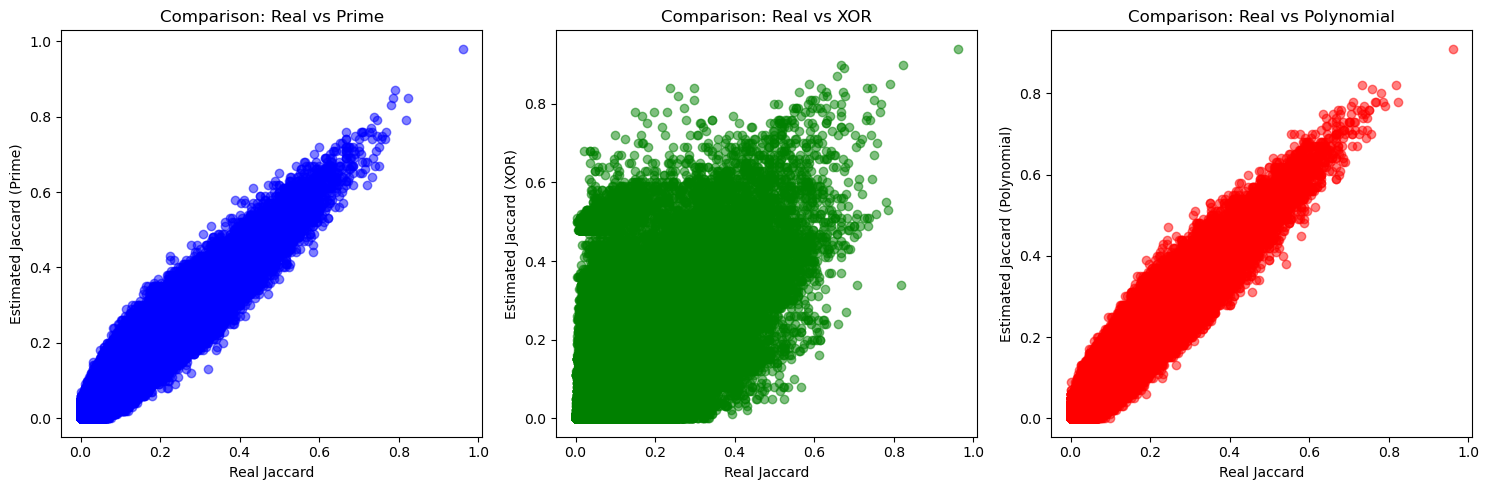

In [15]:
compare_signatures(user_movie_dict, sign_prime, sign_xor, sign_poly, num_samples=2000)

Looking at the results of the mean error, and the plot of the comparisons between real and estimated Jaccard, is shown that the two best signatures are Prime and Polynomial, having very low average errors that are not far from each other. While, the XOR, even if the mean error is a quite small number, is sensibly higer then the value of other two hash signatures.

We'll look now at metrics to evaluate how good the signatures classifies users as similar or not comparing the result with the real classification.

In [ ]:
def evaluate_hash_accuracy(user_movie_dict, minhash_signatures, num_thresholds=10):
    """Evalue the accuracy of the hash signature using Jaccard similarity estiimated vs real. """
    
    # Taking a semple of 2000 users
    users = list(user_movie_dict.keys())
    sampled_users = random.sample(users, 2000)

    thresholds = [i / num_thresholds for i in range(1, num_thresholds + 1)]
    
    y_true = []  # Ground truth (real Jaccard values)
    y_pred = []  # Predicted Jaccard values (using MinHash)
    
    for i in range(len(sampled_users)):
        user1 = sampled_users[i]
        for j in range(i + 1, len(sampled_users)):
            user2 = sampled_users[j]
            
            # Computing the real Jaccard 
            real_jaccard = jaccard_real(user_movie_dict, user1, user2)
            
            # Computing the predicted Jaccard
            signature1 = minhash_signatures[user1]
            signature2 = minhash_signatures[user2]
            estimated_jaccard = jaccard_estimated(signature1, signature2)
            
            # Adding the similarities to comparisons
            y_true.append(real_jaccard)
            y_pred.append(estimated_jaccard)

    # Compare with different thresholds
    results = {}
    for threshold in thresholds:
        # Giving 1 if similarity is above threshold, 0 otherwise
        y_true_binary = [1 if true >= threshold else 0 for true in y_true]
        y_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred]

        # Compute precision, recall, and F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(y_true_binary, y_pred_binary, average='binary')
        
        # Saving the results of metrics
        results[threshold] = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    return results

In [17]:
results = evaluate_hash_accuracy(user_movie_dict, sign_prime)
for threshold, metrics in results.items():
    print(f"Threshold: {threshold:.2f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")

Threshold: 0.10, Precision: 0.6309, Recall: 0.9281, F1: 0.7512
Threshold: 0.20, Precision: 0.5962, Recall: 0.8954, F1: 0.7158
Threshold: 0.30, Precision: 0.6747, Recall: 0.8446, F1: 0.7501
Threshold: 0.40, Precision: 0.7193, Recall: 0.8081, F1: 0.7611
Threshold: 0.50, Precision: 0.7429, Recall: 0.7853, F1: 0.7635
Threshold: 0.60, Precision: 0.7668, Recall: 0.8158, F1: 0.7905
Threshold: 0.70, Precision: 0.7077, Recall: 0.8214, F1: 0.7603
Threshold: 0.80, Precision: 0.6667, Recall: 0.8889, F1: 0.7619
Threshold: 0.90, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Threshold: 1.00, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Here the better threshold with the better combination of high-value metrics is threshold=0.60, precision=0.77, recall=0.82, F1=0.79.

In [18]:
results = evaluate_hash_accuracy(user_movie_dict, sign_xor)
for threshold, metrics in results.items():
    print(f"Threshold: {threshold:.2f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")

Threshold: 0.10, Precision: 0.7591, Recall: 0.3344, F1: 0.4643
Threshold: 0.20, Precision: 0.6054, Recall: 0.4213, F1: 0.4969
Threshold: 0.30, Precision: 0.4976, Recall: 0.4197, F1: 0.4553
Threshold: 0.40, Precision: 0.3431, Recall: 0.4284, F1: 0.3810
Threshold: 0.50, Precision: 0.1907, Recall: 0.4635, F1: 0.2702
Threshold: 0.60, Precision: 0.2002, Recall: 0.5123, F1: 0.2879
Threshold: 0.70, Precision: 0.1498, Recall: 0.4805, F1: 0.2284
Threshold: 0.80, Precision: 0.0833, Recall: 0.5000, F1: 0.1429
Threshold: 0.90, Precision: 0.2000, Recall: 1.0000, F1: 0.3333
Threshold: 1.00, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


As we could immagine having see the results of the Mean Error, XOR has worst results then the prime hash.

In [19]:
results = evaluate_hash_accuracy(user_movie_dict, sign_poly)
for threshold, metrics in results.items():
    print(f"Threshold: {threshold:.2f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")

c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Threshold: 0.10, Precision: 0.6159, Recall: 0.9324, F1: 0.7418
Threshold: 0.20, Precision: 0.6004, Recall: 0.9415, F1: 0.7332
Threshold: 0.30, Precision: 0.6252, Recall: 0.9365, F1: 0.7498
Threshold: 0.40, Precision: 0.6199, Recall: 0.9138, F1: 0.7387
Threshold: 0.50, Precision: 0.6244, Recall: 0.8759, F1: 0.7291
Threshold: 0.60, Precision: 0.5766, Recall: 0.8114, F1: 0.6741
Threshold: 0.70, Precision: 0.4756, Recall: 0.7091, F1: 0.5693
Threshold: 0.80, Precision: 0.4286, Recall: 0.7500, F1: 0.5455
Threshold: 0.90, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Threshold: 1.00, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Here we have better metrics values than the XOR ones, but they are not as good as the values we have seen in the prime signatures. We are not considerign the too low or high tresholds, beacuse they could create misleading values, classifying all users as similar or non-similar as long as they are above a threshold that is too low, or below a threshold that is too high. So the best hash is the Prime, having a good combination of performances values with an acceptable threshold.

### Locality-Sensitive Hashing (LSH) from Scratch

**`lsh_scratch(minhash_signatures, num_bands, rows_per_band)`**

1. **Purpose**  
   - Implements the LSH algorithm to group users with similar MinHash signatures into the same buckets and identify candidate pairs for similarity checks.

2. **Parameters**  
   - `minhash_signatures`: Dictionary of users and their MinHash signatures.  
   - `num_bands`: Number of bands to divide the signatures into.  
   - `rows_per_band`: Number of rows in each band.

3. **Logic**  
   - **Assertion Check:** Ensures the total number of rows in bands matches the signature length.  
   - **Initialization:**
     - `buckets`: Stores all users grouped by their bucket hash.
     - `candidate_pairs`: Holds all user pairs identified as candidates for similarity.  
   - **Band Processing:**  
     - For each band, slice the signature into sub-sections (`start_idx:end_idx`).  
     - Hash each band to a `band_hash` and group users with the same hash into `band_buckets`.
     - Print debug information: Band number, hash, and grouped users.
   - **Update Buckets:**  
     - Add the users in `band_buckets` to the global `buckets` structure.  
   - **Identify Candidate Pairs:**  
     - For users in the same `band_buckets` group, generate all possible user pairs.

4. **Return Values**  
   - `buckets`: Dictionary containing users grouped by bucket hash.  
   - `candidate_pairs`: Set of user pairs identified as candidates for further similarity evaluation.

5. **Key Steps:**
   - **Band Hashing:**  
     Users with similar MinHash signatures fall into the same bucket, increasing the likelihood of finding similar users.
   - **Candidate Pair Generation:**  
     User pairs in the same bucket are flagged as potentially similar for detailed similarity checks.

**Debugging Output:**  
For each band, the band index, hash values, and associated users are printed for tracking progress.


In [15]:
def lsh_scratch(minhash_signatures, num_bands, rows_per_band):
    assert num_bands * rows_per_band == len(list(minhash_signatures.values())[0]), \
        "ERROR: num_bands * rows_per_band does not match the signature length."

    prime = next_prime(len(minhash_signatures))
    buckets = defaultdict(list)
    candidate_pairs = set()
    computation_counter = 0

    for band_idx in range(num_bands):
        band_buckets = defaultdict(list)

        for user, signature in minhash_signatures.items():
            start_idx = band_idx * rows_per_band
            end_idx = start_idx + rows_per_band
            band = tuple(signature[start_idx:end_idx])

            band_hash = 0
            for i, value in enumerate(band):
                band_hash += (value * (i + 1)) % prime  
                computation_counter += 1
              # Built-in Python hash
            band_buckets[band_hash].append(user)
            
            if computation_counter % 400000 == 0:
                print(f"Computed {computation_counter} hashes so far out of total {num_bands * len(minhash_signatures) * rows_per_band}.")
        # Add users to general buckets
        for band_hash, users in band_buckets.items():
            buckets[band_hash].extend(users)

        # Check for candidate pairs
        for bucket_users in band_buckets.values():
            if len(bucket_users) > 1:
                for i in range(len(bucket_users)):
                    for j in range(i + 1, len(bucket_users)):
                        candidate_pairs.add((bucket_users[i], bucket_users[j]))

    return buckets, candidate_pairs


In [18]:
num_bands = 10
rows_per_band = 10

buckets, candidate_pairs = lsh_scratch(sign_prime, num_bands, rows_per_band)

Computed 400000 hashes so far out of total 13849300.
Computed 800000 hashes so far out of total 13849300.
Computed 1200000 hashes so far out of total 13849300.
Computed 1600000 hashes so far out of total 13849300.
Computed 2000000 hashes so far out of total 13849300.
Computed 2400000 hashes so far out of total 13849300.
Computed 2800000 hashes so far out of total 13849300.
Computed 3200000 hashes so far out of total 13849300.
Computed 3600000 hashes so far out of total 13849300.
Computed 4000000 hashes so far out of total 13849300.
Computed 4400000 hashes so far out of total 13849300.
Computed 4800000 hashes so far out of total 13849300.
Computed 5200000 hashes so far out of total 13849300.
Computed 5600000 hashes so far out of total 13849300.
Computed 6000000 hashes so far out of total 13849300.
Computed 6400000 hashes so far out of total 13849300.
Computed 6800000 hashes so far out of total 13849300.
Computed 7200000 hashes so far out of total 13849300.
Computed 7600000 hashes so far

In [20]:
dict(list(buckets.items())[:3])

{6323: [1,
  42734,
  60230,
  69214,
  97106,
  111931,
  129839,
  1690,
  5582,
  7534,
  52632,
  128901,
  137243,
  71570,
  93433,
  11966,
  32239,
  40918,
  48402,
  64182,
  87943,
  95572,
  99026,
  114799,
  123310,
  22203,
  69139,
  70387,
  105371,
  107060,
  123104,
  36742,
  71575,
  131905,
  14738,
  98215,
  125385,
  130499,
  6056,
  14852,
  79086,
  80082,
  85681,
  105712,
  136116,
  1826,
  40003,
  78858,
  85884,
  50729],
 34845: [2,
  35793,
  6336,
  12776,
  107000,
  45242,
  84804,
  114436,
  34480,
  88691,
  118223,
  118975,
  119857,
  29118,
  133833,
  21973,
  110358,
  111592,
  116532],
 8546: [3,
  11108,
  15273,
  97432,
  12279,
  31428,
  36005,
  43127,
  53405,
  75294,
  107788,
  111853,
  117431,
  28960,
  124818,
  133853,
  72701,
  35646,
  47787,
  110419,
  17006,
  55018,
  67256,
  72328,
  86100,
  131944,
  6723,
  17424,
  25277,
  38609,
  55007,
  124715,
  126296,
  136554,
  26021,
  29217,
  99779,
  107272,
 

In [22]:
list(candidate_pairs)[:20]

[(3312, 71878),
 (39212, 100558),
 (17882, 55660),
 (44866, 130777),
 (49415, 125780),
 (17463, 30601),
 (46984, 80861),
 (62263, 111183),
 (68246, 137898),
 (15694, 67839),
 (55110, 107705),
 (59076, 60279),
 (39002, 102441),
 (83046, 118944),
 (30204, 108910),
 (20267, 88533),
 (79626, 137267),
 (60645, 109340),
 (103528, 126565),
 (30153, 34262)]

In [23]:
len(buckets)

104292

In [24]:
len(candidate_pairs)

2148807

### Finding Similar Users

**Function:** `find_similar_users(candidate_pairs, user_movie_dict)`

This function identifies and ranks similar users based they real Jaccard similarity, leveraging the candidate pairs generated by the LSH algorithm.

---

#### **1. Parameters**
- **`candidate_pairs`**: Set of user pairs identified as potentially similar.  
- **`user_movie_dict`**: Dictionary mapping users to the list of movies they have rated.
- **`target_user`**: User whose similar users we want to find.
- **`top_k`**: Number of more similar users we want to get back.

---

#### **2. Logic**
- **Step 1: Calculate Common Movies**  
  - For each user pair in `candidate_pairs` which have the target user:  
    - Compute the Jaccard similarity based on their seen movies.  
    - Round the similarity score to a better visualization.
    - If the similarity is non-0, add the pair to the `similar_users` dictionary, along with the similarity score.  

- **Step 2: Sort Similar Users**  
  - Sort their list of similar users in descending order of the similarity score.

---

#### **3. Return Value**
- **`similar_users`**:  
  A dictionary where each one of top_k most similar user is mapped to the number of common movies with the target user.  

---

#### **4. Example Workflow**

**Input:**  
```python
candidate_pairs = {('User1', 'User2'), ('User1', 'User3')}
user_movie_dict = {
    'User1': [101, 102, 103],
    'User2': [101, 103, 104],
    'User3': [102, 105]
}
target_user = 'User1'



---

**Output:**  
```python
{
    'User2': 2,
    'User3': 1
}


In [28]:
def find_similar_users(candidate_pairs, user_movie_dict, target_user, top_k = 2):
    similar_users = defaultdict(list)  

    for user1, user2 in candidate_pairs:
        # considering just the pairs with the target user
        if user1 == target_user or user2 == target_user:
            score = jaccard_real(user_movie_dict, user1, user2)
            score = round(score, 3)

            if score != 0:
                if user1 == target_user:
                    similar_users[user2] = score
                else:    
                    similar_users[user2] = score

    similar_users = {user: score for user, score in sorted(similar_users.items(), key=lambda item: item[1], reverse=True)}

    similar_users = dict(sorted(similar_users.items(), key=lambda x: x[1], reverse=True)[:top_k])
    
    return similar_users


In [29]:
similar_users = find_similar_users(candidate_pairs, user_movie_dict, 1)

In [30]:
similar_users

{115853: 0.196, 126213: 0.173}

### Movie Recommendation Function

**Function:** `recommend_movies(user, similar_users, user_movie_dict, rating_dict, max_recommendations=5)`

This function recommends movies to a user based on the preferences of similar users.

---

#### **1. Parameters**
- **`user`**: The target user for whom the recommendations are generated.  
- **`similar_users`**:   A dictionary where each similar user is mapped to the similarity score with the target user.    
- **`user_movie_dict`**: A dictionary mapping users to the list of movies they have rated.  
- **`rating_dict`**: A dictionary mapping users to their movie ratings as `{movieId: rating}`.  
- **`min_movies`**: The minimum number of movies to have to choose the recommendations (default is 10).

---

#### **2. Logic**
1. **Identify Movies Already Watched**  
   - Extract the list of movies the target user has already watched to avoid recommending these.

2. **Iterate Over Similar Users**  
   - For each similar user:
     - Identify the movies they have watched but the target user has not (`unseen_movies`).

3. **Aggregate Ratings for Unseen Movies**  
   - For each unseen movie:
     - If it is not already in the recommendation list, add it with the similar user's rating.
     - If it is already in the list, add the rating to its existing score.  
   - This ensures that movies recommended by multiple similar users receive a higher score.

4. **Check if the min_movies is reached**  
   - If not we'll look for another user to get other movies until we reach the min_movies.

5. **Return Recommendations**  
   - Return the movies that can be the best candidates to recommend. 

---

#### **3. Return Value**
- A DataFrame with userId, movieId, and rating for columns.

---

#### **4. Example Workflow**

**Input:**  
```python
user = 'User1'
similar_user = {
    'User2': 2,
    'User3': 1
}
user_movie_dict = {
    'User1': [101, 102, 103],
    'User2': [101, 103, 104],
    'User3': [102, 105]
}
rating_dict = {
    'User2': {101: 4, 103: 4, 104: 5},
    'User3': {102: 3, 105: 4}
}


---

**Output:**  
```python

| userId  | movieId     | rating  |
|---------|-------------|---------|
| User2   |     104     |   5     |
| User3   |     105     |   4     |  


In [31]:
def recommend_movies(user, similar_users, user_movie_dict, rating_dict, min_movies=10):

    user_movies = set(user_movie_dict[user])  
    recommendations = []  
    total_movies = 0

    for similar_user in similar_users:
        unique_movies = set(user_movie_dict[similar_user]) - user_movies
        for movie in unique_movies:
            rating = rating_dict[similar_user].get(movie, 0)
            recommendations.append({'userId': similar_user, 'movieId': movie, 'rating': rating})
        total_movies += len(unique_movies)


    # If we don't have the desired number of movies we look for another user

    top_k = 2
    while total_movies < min_movies:
        top_k += 1

        extra_users = find_similar_users(candidate_pairs, user_movie_dict, user, top_k)

        # Taking the last user from the dictionary, which is the new similar user
        extra_user = list(extra_users.keys())[-1]
        unique_movies = set(user_movie_dict[extra_user]) - user_movies
        for movie in unique_movies:
            rating = rating_dict[extra_user].get(movie, 0)
            recommendations.append({'userId': extra_user, 'movieId': movie, 'rating': rating})

        total_movies += len(unique_movies)

    recommendations_df = pd.DataFrame(recommendations)

    return recommendations_df

### Creating `rating_dict`

**Purpose:**  
Creates a dictionary mapping each `userId` to their rated `movieId` and corresponding `rating`.

**Steps:**  
1. **Group by `userId`:** Groups movies and ratings for each user.  
2. **`zip` and `dict`:** Combines `movieId` and `rating` into a dictionary for each user.  
3. **Convert to `dict`:** Creates a nested dictionary.

**Result:**  
A dictionary in the format:
```python
{
    'User1': {101: 4.0, 102: 5.0},
    'User2': {103: 3.5, 104: 4.0},
    ...
}


In [32]:
rating_dict = (
    df.groupby('userId')
    .apply(lambda x: dict(zip(x['movieId'], x['rating'])))
    .to_dict()
)


C:\Users\User\AppData\Local\Temp\ipykernel_11768\322617773.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: dict(zip(x['movieId'], x['rating'])))


In [33]:
user_id = 1

similar_users = find_similar_users(candidate_pairs, user_movie_dict, user_id)

recommended_movies = recommend_movies(user_id, similar_users, user_movie_dict, rating_dict)
recommended_movies

,userId,movieId,rating
0,115853,1,3.5
1,115853,33794,3.5
2,115853,6,4.0
3,115853,520,2.5
4,115853,10,2.0
...,...,...,...
362,126213,1527,3.5
363,126213,7160,4.0
364,126213,7162,4.0
365,126213,508,3.5


In [34]:
movie_id_to_title = df.set_index('movieId')['title'].to_dict()

recommended_movies['title'] = recommended_movies['movieId'].map(movie_id_to_title)
recommended_movies.drop(columns='movieId', inplace=True)
recommended_movies


,userId,rating,title
0,115853,3.5,Toy Story (1995)
1,115853,3.5,Batman Begins (2005)
2,115853,4.0,Heat (1995)
3,115853,2.5,Robin Hood: Men in Tights (1993)
4,115853,2.0,GoldenEye (1995)
...,...,...,...
362,126213,3.5,"Fifth Element, The (1997)"
363,126213,4.0,Monster (2003)
364,126213,4.0,Cold Mountain (2003)
365,126213,3.5,Philadelphia (1993)


**Organization of the final recommendation**

We need only to organize the recommendations in the best way possible. The first movies that we should recommend are the ones that have been seen by both the similar users, for this reason we take the best 3 common movies selecting them by the highest avarage rating. After that we can compplete the recommended movies taking now the best-rated movies for each similar user, that are not in common this time, in order to recommend probably the preferred movies by the most similar user, there are high probabilities that the target user can like them too. Each movie will be recommended with the rating to see how much the movie is enjoiable (average rating for common ones) and the user (or users) who saw it specifically.

In [35]:
def final_recommendation(df):
    # check the unique userId
    unique_users = df['userId'].unique()
    
    # taking first 2 users
    user1, user2 = unique_users[:2]
    
    user1_movies = df[df['userId'] == user1]
    user2_movies = df[df['userId'] == user2]
    
    # Finding common movies
    common_movies = pd.merge(user1_movies, user2_movies, on='title')
    
    # Computing avarage rating
    common_movies['rating'] = common_movies[['rating_x', 'rating_y']].mean(axis=1)
    common_movies['userId'] = f'{user1},{user2}'
    common_movies = common_movies[['userId', 'title', 'rating']]
    
    # Sorting for ascending rating
    common_movies_top = common_movies.sort_values('rating', ascending=False).head(3)
    
    # Find unique movies for user 1
    unique_movies_user1 = user1_movies[~user1_movies['title'].isin(user2_movies['title'])]
    unique_movies_user1['userId'] = str(user1)
    unique_movies_user1 = unique_movies_user1[['userId', 'title', 'rating']]
    unique_movies_user1_top = unique_movies_user1.sort_values('rating', ascending=False).head(3)
    
    # Find unique movies for user 2
    unique_movies_user2 = user2_movies[~user2_movies['title'].isin(user1_movies['title'])]
    unique_movies_user2['userId'] = str(user2)
    unique_movies_user2 = unique_movies_user2[['userId', 'title', 'rating']]
    unique_movies_user2_top = unique_movies_user2.sort_values('rating', ascending=False).head(3)
    
    # Combine results
    risultato_finale = pd.concat([common_movies_top, unique_movies_user1_top, unique_movies_user2_top])
    
    return risultato_finale

In [36]:
final_recommendation(recommended_movies)

C:\Users\User\AppData\Local\Temp\ipykernel_11768\1664284511.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_movies_user1['userId'] = str(user1)
C:\Users\User\AppData\Local\Temp\ipykernel_11768\1664284511.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_movies_user2['userId'] = str(user2)


,userId,title,rating
3,"115853,126213","Matrix, The (1999)",5.0
68,"115853,126213",Gladiator (2000),4.5
29,"115853,126213","Godfather: Part II, The (1974)",4.5
7,115853,"Animatrix, The (2003)",4.5
71,115853,Dr. Strangelove or: How I Learned to Stop Worr...,4.5
114,115853,Citizen Kane (1941),4.5
206,126213,Scarface (1983),5.0
214,126213,Training Day (2001),5.0
342,126213,Predator (1987),5.0


### Algorithmic question

#### a) Help Arya by providing a pseudocode for finding an optimal playing strategy, that is, a strategy that maximizes her value. (Hint: Use recursion, assuming that both players play optimally).
The possible strategy is to calculate all the possible final scores that each player can obtain based on the various sequences of possible choices.; <br>
This can be done recursively, simulating all the possible choices and outcomes that can be achieved, assuming that the other player plays optimally.

##### Recursive algorithm explanation:

---

**Input:**  
- `num`: List of numbers.

**Variable inizialized during the algorithm**
- `arya_score`: Arya's score (default is 0).  
- `mario_score`: Mario's score (default is 0).
- `arya_moves`: List of best moves for Arya.
- `mario_moves`: List of best moves for Mario.
- `turn`: Boolean indicating whose turn it is (True for Arya, False for Mario).  

**Output:**  
- Final scores and moves of both players: `(arya_score, mario_score, arya_moves, mario_moves)`.  

--- 

**Algorithm:**

1. **Base Case:**
   - If `num` is empty, return best scores and moves for both players `(arya_score, bran_score, arya_moves, bran_moves)`.

2. **Arya's turn:**
   1. Simulate both choices, create 2 tuples with possible score of both players if Arya choose Head or Tail:
      - `choose_head`: Recursively call the function with `num[1:]` (excluding the head), adding `num[0]` to `arya_score` and appending head number `num[0]` to her moves.
      - `choose_tail`: Recursively call the function with `num[:-1]` (excluding the tail), adding `num[-1]` to `arya_score` and appending tail number `num[-1]` to her moves.
   2. Compare the results:
      - If head choice is better than tail choice, `choose_head[0] > choose_tail[0]`, return *choose_head*, which contains best scores and moves for both players if Arya choose to follow head number path.
      - Otherwise, return *choose_tail*, which contains best scores and moves for both players if Arya choose to follow tail number path.

3. **Mario's turn:**
   1. Simulate both choices, create 2 tuples with possible score of both players if Mario choose Head or Tail:
      - `choose_head`: Recursively call the function with `num[1:]` (excluding the head), adding `num[0]` to `mario_score` and appending head number `num[0]` to his moves.
      - `choose_tail`: Recursively call the function with `num[:-1]` (excluding the tail), adding `num[-1]` to `mario_score` and appending tail number `num[-1]` to his moves.
   2. Compare the results:
      - If head choice is better than tail choice, `choose_head[1] > choose_tail[1]`, return *choose_head*, which contains best scores and moves for both players if Mario choose to follow head number path.
      - Otherwise, return choose_tail, which contains best scores and moves for both players if Mario choose to follow tail number path.

##### Recursive algorithm pseudocode:

**Algorithm: *recursive_strategy(num)***

**INITIALIZE** arya_score <- 0 <br>
**INITIALIZE** mario_score <- 0 <br>
**INITIALIZE** arya_moves <- [] <br>
**INITIALIZE** mario_moves <- [] <br>

***Base case:***
1. **IF** *len(num) == 0* 
    - **return** *(arya_score, mario_score, arya_moves, mario_moves)*

***Arya's turn:*** <br>

2. **IF** *turn == True*:  
    - **choose_head** <- ***recursive_strategy**(num[1:], arya_score + num[0], mario_score, arya_moves + [num[0]], mario_moves, !turn)*
    - **choose_tail** <- ***recursive_strategy**(num[:-1], arya_score + num[-1], mario_score, arya_moves + [num[-1]], mario_move, !turn)*

    - **if** *choose_head[0] > choose_tail[0]*:
      - **return** *choose_head*
    - **else**
      - **return** *choose_tail*

***Mario's turn***

3. **ELSE**
    - **choose_head** <- ***recursive_strategy**(num[1:], arya_score, mario_score + num[0], arya_moves, mario_moves + [ num[0] ], !turn)*
    - **choose_tail** <- ***recursive_strategy**(num[:-1], arya_score, mario_score + num[-1], arya_moves, mario_moves + [ num[-1] ], !turn)*  
  
    - **IF** *choose_head[1] > choose_tail[1]*:
      - **return** *choose_head*
    - **ELSE**
      - **return** *choose_tail* 

#### b) Write a Python program implementing her game strategy. Try different array lengths to test the algorithm.

In [ ]:
def recursive_strategy(num, arya_score=0, mario_score=0, arya_moves=None, mario_moves=None, turn=True):
    if arya_moves is None:
        arya_moves = []
    if mario_moves is None:
        mario_moves = []

    # Base case, num empty
    if not num:
        return arya_score, mario_score, arya_moves, mario_moves

    # Arya's turn
    if turn:  
        # Simulate best possible scores and moves for head and tail
        choose_head = recursive_strategy(num[1:], 
                                         arya_score + num[0], 
                                         mario_score, 
                                         arya_moves + [num[0]], 
                                         mario_moves, 
                                         not turn)
        
        choose_tail = recursive_strategy(num[:-1], 
                                         arya_score + num[-1], 
                                         mario_score, 
                                         arya_moves + [num[-1]], 
                                         mario_moves, not turn)

        # Arya selects the move that maximizes her score
        if choose_head[0] > choose_tail[0]:
            return choose_head
        else:
            return choose_tail

    # Mario's turn
    else:  
        # Simulate best possible scores and moves for head and tail
        choose_head = recursive_strategy(num[1:], 
                                         arya_score, 
                                         mario_score + num[0], 
                                         arya_moves, 
                                         mario_moves + [num[0]], 
                                         not turn)
        
        choose_tail = recursive_strategy(num[:-1], 
                                         arya_score, 
                                         mario_score + num[-1], 
                                         arya_moves, 
                                         mario_moves + [num[-1]], 
                                         not turn)

        # Mario selects the move that maximizes his score
        if choose_head[1] > choose_tail[1]:
            return choose_head
        else:
            return choose_tail

# Example usage
# Example usage on different size lists
random.seed(123)

listSize = 7
trySize = 10

nums = [[random.randint(1, 100) for _ in range(i)] for i in range (3, trySize)]

for num in nums:
    print("List", num)
    n = len(num)
    arya_score, mario_score, arya_moves, mario_moves = recursive_strategy(num, n)
    print("Arya's best score:", arya_score)
    print("Arya best strategy is to take, in sequence", mario_moves)
    print()



List [7, 35, 12]
Arya's best score: 22
Arya best strategy is to take, in sequence [35]

List [99, 53, 35, 14]
Arya's best score: 138
Arya best strategy is to take, in sequence [53, 14]

List [5, 49, 69, 72, 43]
Arya's best score: 122
Arya best strategy is to take, in sequence [72, 49]

List [44, 7, 21, 18, 44, 72]
Arya's best score: 143
Arya best strategy is to take, in sequence [44, 18, 7]

List [43, 90, 32, 21, 1, 56, 100]
Arya's best score: 183
Arya best strategy is to take, in sequence [56, 21, 90]

List [12, 77, 49, 9, 1, 41, 94, 58]
Arya's best score: 193
Arya best strategy is to take, in sequence [94, 1, 49, 12]

List [14, 6, 12, 86, 19, 17, 3, 38, 56]
Arya's best score: 113
Arya best strategy is to take, in sequence [38, 17, 6, 86]



#### c) Is the algorithm efficient? Prove that it is polynomial and provide an asymptotic time complexity bound, or show that it requires exponential time.

**Computational Cost Analysis**

This algorithm exhaustively explores all possible combinations of moves for Arya and Mario. Each recursive branch represents a decision (choosing head or tail) and explores all subsequent moves optimally. Without memoization, the same subproblems (overlapping intervals) are recalculated multiple times, leading to exponential time growth.

1. ***Function Behavior***: <br>
At each step, the function simulates both possible moves (taking the number at the head or the tail of the list). <br>
The size of the list `num` decreases by 1 at each recursive call, but for every call, two branches of the recursion are created and explored.

2. ***Recursive Tree Depth***: <br>
The recursion depth is equal to the number of elements in the list num, which is `n`, this takes ***O(n)*** time.

3. ***Number of Recursive Calls***: <br>
For a list of length `n` the recursion tree has **2<sup>n</sup> - 1** nodes because every choice branches into two further calls.

4. ***Overall Time Complexity***: <br>
Given that decision over the n numbers of the list create two recursive call, in `point 2.1` for Arya and in `point 3.1` for Mario, and that they also create other 2 recursive call each, the total time complexity of the algortihm is **exponential**, in particular, it is **O(n 2<sup>n</sup>)**




#### d) *If the algorithm is exponential, explain how to make it polynomial and provide a pseudocode for it. Recompute the computational complexity of the updated algorithm.*

The following algorithm solves the problem using dynamic programming. The algorithm builds a table to store the results of subarray calculations, avoiding redundant computations, as we did in recursive algorithm.

---

**Input:**  
- `num`: List of numbers.

**Output:**  
- Final scores and moves of both players:  
  - `Arya_score`: Arya's score.  
  - `mario_score`: mario's score.  
  - `Arya_moves`: List of best moves for Arya.
  - `mario_moves`: List of best moves for Mario.

---

**Algorithm:**

1. **Initialization:**  
   - Create a 2D table `score_table` to store maximum score difference for the current player subarrays `num[i:j+1]`.
   - Another 2D table moves is created to store sequence of moves both players takes when playing optimally on subarrays `num[i:j+1]`.
   - `total_sum` accumulates the sum of all elements in the array.

2. **Fill up the table:**
    
   - If there is only one element in the subarray `i == j`, Arya takes it.  
   - Otherwise, Arya has two choices and takes the one that maximized her score difference:  
     - **Arya's Choices:**  
       1. Pick the first element `num[i]` and let Mario play optimally in the remaining subarray `num[i+1:j+1]`.
       2. Pick the last element `num[j]` and let Mario play optimally in the remaining subarray `num[i:j]`.  

3. **Moves tracking:**
    - If Arya picks the first element, the move is added to the sequence, followed by the optimal sequence for `num[i+1:j+1]`
    - If Arya picks the last element, the move is added to the sequence, followed by the optimal sequence for `num[i:j]`

4. **Result:**
    - The final answer for the entire array is stored in `score_table[0][n-1]`. Return the scores and moves from this cell.


##### Optimized Algorithm Pseudocode

**Algorithm: optimized_game(num, n):**

1. Initialization
    - total_sum <- 0 <br>
    - **CREATE** 2D array *score_table[ n ][ n ]* initialized to *0* <br>
    - **CREATE** 2D array *moves[ n ][ n ]* initialized to *empty lists* <br>

2. Iteratively fill up the score_table

    - **FOR** *i* **FROM** *n-1* **TO** *0*: 
        - **total_sum** += *num[ i ]* <br>
        
        - **FOR** *j* **FROM** *i* **TO** *n-1*:
            - **IF** *i == j*:
                - **score_table[ i ][ j ]** <- *num[ i ]*
                - **moves[ i ][ j ]** <- *[ num[ i ] ]*
            - **ELSE**:
                - **pick_start** <- *num[ i ] - score_table[ i+1 ][ j ]*
                - **pick_end** <- *num[j] - score_table[ i ][ j-1 ]*

                - **IF** *pick_start > pick_end*:
                    - score_table[ i ][ j ] <- *pick_start*
                    - moves[ i ][ j ] <- *[ num[ i ] ] + moves[ i+1 ][ j ]*
                - **ELSE**:
                    - **score_table[ i ][ j ]** <- *pick_end*
                    - **moves[ i ][ j ]** <- *[ num[ j ] ] + moves[ i ][ j-1 ]*

- **arya_score** <- *(total_sum + score_table[ 0 ][ n-1 ]) // 2*
- **RETURN** *arya_score*, *mario_score*, *moves[ 0 ][ n-1 ]*, *moves[0][n - 1][1::2]*

#### e) *Implement the algorithm in Python. Compare your result values with the previous algorithm. Also compare the running times.*

In [4]:
import random

def optimized_game(num, n):
    # Total sum of numbers in the list
    total_sum = 0
    # Table for score storing
    score_table = [[0] * n for _ in range(n)] 
    # Table for moves tracking
    moves = [[[] for _ in range(n)] for _ in range(n)]  # Move tracking
    
    # Iterate from the end to the start
    for i in range(n - 1, -1, -1):
        total_sum += num[i]
        for j in range(i, n):
            if i == j:
                score_table[i][j] = num[i]
                moves[i][j] = [num[i]]  # Single element, pick it
            else:
                # Two options: pick the head number (start) or the tail number (end)
                pick_start = num[i] - score_table[i + 1][j]
                pick_end = num[j] - score_table[i][j - 1]
                
                if pick_start > pick_end:
                    score_table[i][j] = pick_start
                    # Pick start and add the rest
                    moves[i][j] = [num[i]] + moves[i + 1][j]
                else:
                    score_table[i][j] = pick_end
                    # Pick end and add the rest
                    moves[i][j] = [num[j]] + moves[i][j - 1]  
                    
    # Calculate Arya's maximum score
    arya_score = (total_sum + score_table[0][n - 1]) // 2
    # Create return variables [arya_score, mario_score, arya_moves, mario_moves]
    return arya_score, total_sum - arya_score, moves[0][n - 1][::2], moves[0][n - 1][1::2]


# Example usage on different size lists
random.seed(123)

listSize = 7
trySize = 10

nums = [[random.randint(1, 100) for _ in range(i)] for i in range (3, trySize)]

for num in nums:
    print("List", num)
    n = len(num)
    arya_score, mario_score, arya_moves, mario_moves = optimized_game(num, n)
    print("Arya's best score:", arya_score)
    print("Arya best strategy is to take, in sequence", mario_moves)
    print()

List [7, 35, 12]
Arya's best score: 19
Arya best strategy is to take, in sequence [35]

List [99, 53, 35, 14]
Arya's best score: 134
Arya best strategy is to take, in sequence [53, 14]

List [5, 49, 69, 72, 43]
Arya's best score: 117
Arya best strategy is to take, in sequence [72, 49]

List [44, 7, 21, 18, 44, 72]
Arya's best score: 137
Arya best strategy is to take, in sequence [44, 18, 7]

List [43, 90, 32, 21, 1, 56, 100]
Arya's best score: 176
Arya best strategy is to take, in sequence [56, 21, 90]

List [12, 77, 49, 9, 1, 41, 94, 58]
Arya's best score: 185
Arya best strategy is to take, in sequence [94, 1, 49, 12]

List [14, 6, 12, 86, 19, 17, 3, 38, 56]
Arya's best score: 104
Arya best strategy is to take, in sequence [38, 17, 6, 86]



**Computational Cost Analysis**
- Initialization of tables take, each, ***O(n<sup>2</sup>)***, where n is the size of the list of number.
- Filling the table involves two nested loops:
    -   Outer loop: ***O(n)***
    -   Inner loop: ***O(n)***
    -   For each iteration in the inner loop, constant time ***O(1)*** work is done (calculating scores and updating moves).
    -   Overall time complexity of filling up step is ***O(n<sup>2</sup>)***
- Calculating Arya's score is done in costant time ***O(1)***.

Overall time complexity is ***O(n<sup>2</sup>)***, **polynomial** time.

#### f) Finally, consult LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to craft a third, optimized implementation and analyze its time complexity. Also, explain if the LLM is doing a good job and how you can evaluate whether the suggested solution works properly.

In [5]:
def LLM_game(num):
    n = len(num)
    # Initialize DP table to store scores and moves of both players [arya_score, mario_score, arya_moves, mario_moves]
    dp = [[[0, 0, [], []] for _ in range(n)] for _ in range(n)]

    # Fill the DP table

    # Subarryas of length 1
    for i in range(n):
        dp[i][i] = [num[i], 0, [num[i]], []]

    # Subarray of length in range (2, len(num))
    for length in range(2, n + 1):
        for i in range(n - length + 1):
            j = i + length - 1
            # Arya's choices: pick head or tail
            head_arya_score = num[i] + dp[i + 1][j][1]
            tail_arya_score = num[j] + dp[i][j - 1][1]

            if head_arya_score > tail_arya_score:
                dp[i][j][0] = head_arya_score  # Arya's score
                dp[i][j][1] = dp[i + 1][j][0]  # Mario's score
                dp[i][j][2] = [num[i]] + dp[i + 1][j][3]  # Arya's moves
                dp[i][j][3] = dp[i + 1][j][2]  # Mario's moves
            else:
                dp[i][j][0] = tail_arya_score  # Arya's score
                dp[i][j][1] = dp[i][j - 1][0]  # Mario's score
                dp[i][j][2] = [num[j]] + dp[i][j - 1][3]  # Arya's moves
                dp[i][j][3] = dp[i][j - 1][2]  # Mario's moves

    # Final scores and moves
    final_scores_and_moves = dp[0][n - 1]

    return final_scores_and_moves

# Example usage on different size lists
random.seed(123)

listSize = 7
trySize = 10

nums = [[random.randint(1, 100) for _ in range(i)] for i in range (3, trySize)]

for num in nums:
    print("List", num)
    n = len(num)
    arya_score, mario_score, arya_moves, mario_moves = LLM_game(num)
    print("Arya's best score:", arya_score)
    print("Arya best strategy is to take, in sequence", arya_moves)
    print()


List [7, 35, 12]
Arya's best score: 19
Arya best strategy is to take, in sequence [12, 7]

List [99, 53, 35, 14]
Arya's best score: 134
Arya best strategy is to take, in sequence [99, 35]

List [5, 49, 69, 72, 43]
Arya's best score: 117
Arya best strategy is to take, in sequence [43, 69, 5]

List [44, 7, 21, 18, 44, 72]
Arya's best score: 137
Arya best strategy is to take, in sequence [72, 44, 21]

List [43, 90, 32, 21, 1, 56, 100]
Arya's best score: 176
Arya best strategy is to take, in sequence [100, 1, 32, 43]

List [12, 77, 49, 9, 1, 41, 94, 58]
Arya's best score: 185
Arya best strategy is to take, in sequence [58, 41, 9, 77]

List [14, 6, 12, 86, 19, 17, 3, 38, 56]
Arya's best score: 104
Arya best strategy is to take, in sequence [56, 3, 14, 19, 12]



**Computational time analysis**: The optimized_game function efficiently computes Arya's and Mario's scores and their respective moves using a dynamic programming approach.

The algorithm is composed of:
- Initialization of dp table, that takes ***O(n<sup>2</sup>)*** to fill the table with zeros, where n is the size of the list of numbers. 
- A for loop that iterates ***O(n)*** times to fill the diagonal of the table to initialize single subarrays tuples.
- Two for loop that iterates almost *n* times each, so this nested loops runs in ***O(n<sup>2</sup>)*** time complexity.
- Final variable, *final_scores_and_moves*, is created in O(n) time due to iteration over all columns of the table.


So, the overall time complexity is ***O(n<sup>2</sup>)***, polynomial complexity.

**Correctness**: The proposed approach uses dynamic programming to simulate the optimal strategy for Arya. Each player's optimal choices are taken into account, and the base case and recurrence relation correctly model the dynamics of the game. The solution ensures that Arya plays optimally, assuming that both players make the best possible moves at every step.

**Validation**: To validate the results of these 3 algorithms, let's graph the success percentage on the same sets of lists of numbers. Since the 3 lines are overlapping, this means that they maximize the score in the same way.

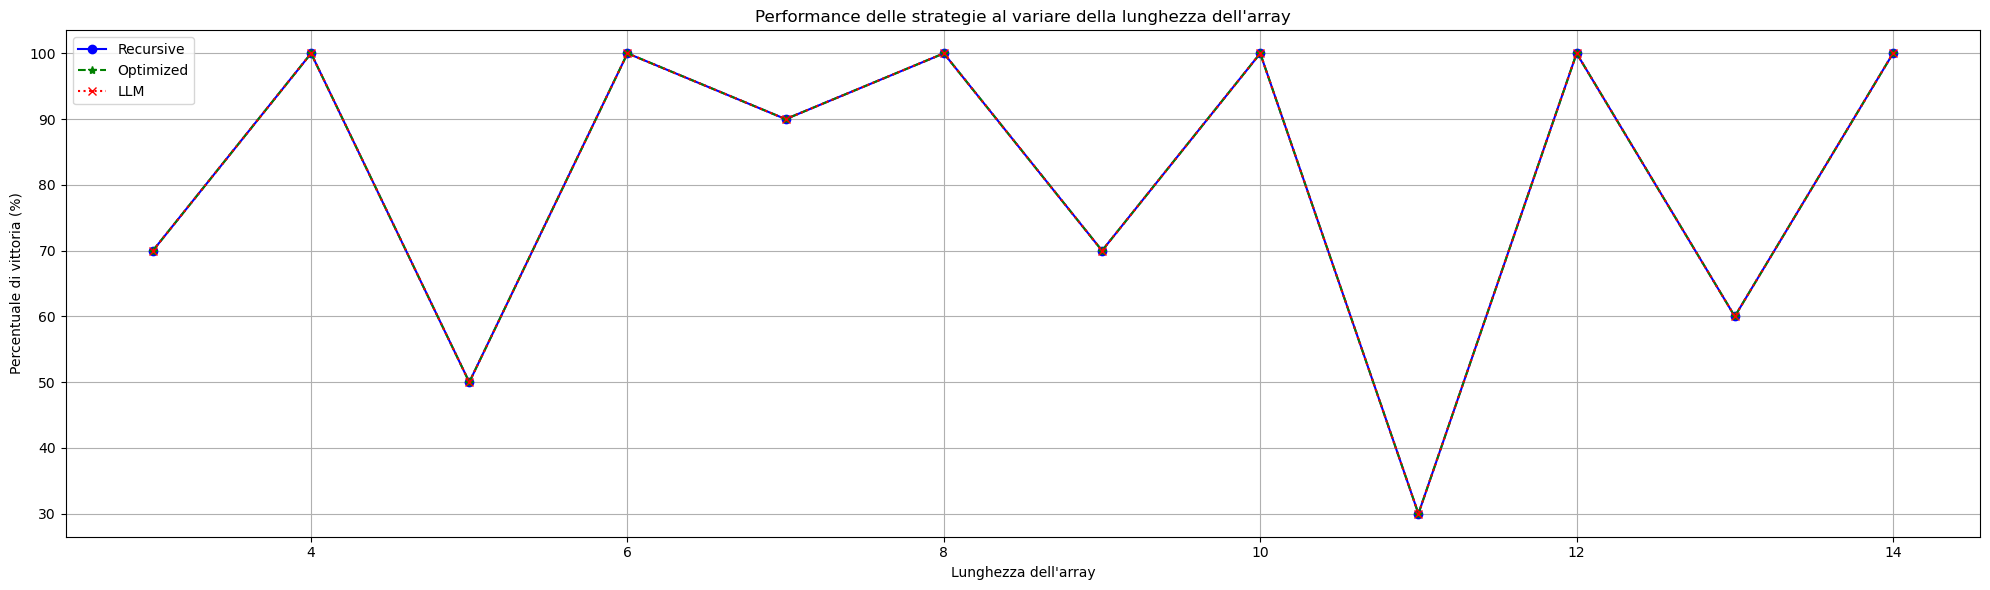

In [ ]:
import matplotlib.pyplot as plt
import random

# Function to test the strategies
def test_strategies(maxListSize, iterations=100):
    results = {
        "recursive_strategy": [],
        "optimized_strategy": [],
        "LLM_strategy": []
    }

    # Test different size list of numbers
    for n in range(3, maxListSize):
        # Variables to track each strategie number of Arya's win over Mario
        rec_wins = 0
        optim_wins = 0
        llm_wins = 0

        # Create multiple lists of different sizes to be tested
        nums = [[random.randint(1, 100) for _ in range(n)] for i in range(iterations)]

        for num in nums:
            # Recursive Strategy
            arya_score, mario_score, arya_moves, mario_moves = recursive_strategy(num.copy())
            if arya_score > mario_score: 
                rec_wins += 1

            # Optimized Strategy
            arya_score, mario_score, arya_moves, mario_moves = optimized_game(num.copy(), len(num))
            if arya_score > mario_score: 
                optim_wins += 1

            # LLM Strategy
            arya_score, mario_score, arya_moves, mario_moves = LLM_game(num.copy())
            if arya_score > mario_score: 
                llm_wins += 1
                

        # Calculate the win percentages
        results["recursive_strategy"].append(rec_wins / iterations * 100)
        results["optimized_strategy"].append(optim_wins / iterations * 100)
        results["LLM_strategy"].append(llm_wins / iterations * 100)

    return results

# Lists max size
maxListSize = 15
# Number of tests for each size
iterations = 10  

# Test the strategies
results = test_strategies(maxListSize, iterations)

# Plot the results
plt.figure(figsize=(20, 6))

plt.plot(nums, results["recursive_strategy"], label="Recursive", marker="o", color="blue", linestyle="-")
plt.plot(nums, results["optimized_strategy"], label="Optimized", marker="*", color="green", linestyle="--")
plt.plot(nums, results["LLM_strategy"], label="LLM", marker="x", color="red", linestyle=":")

plt.title("Performance of strategies based on array size")
plt.xlabel("Array size")
plt.ylabel("Win percentage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()  # To avoid label cutting
plt.show()
